In [6]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

from vsim.optimization.data_center import VSDataCenter
from vsim.optimization.solver import VSSolver
from vsim.utils import get_vehicle_last_track, estimate_start_time, get_overlapping_processes, manhattan_distance 
import re
import matplotlib.dates as mdates

In [24]:
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

In [25]:
file_path = "../data/VOSimu-InputInformation.xlsx"

In [26]:
import pm4py

simulated_event_log = pm4py.read_xes("../outputs/simulation_v1.xes")

PROCESS_START_TIME: pd.Timestamp = simulated_event_log.timestamp.min().to_pydatetime()

parsing log, completed traces ::   0%|          | 0/286 [00:00<?, ?it/s]

In [27]:
data_center = VSDataCenter(data_file=file_path)
solver = VSSolver(data_center=data_center)

In [28]:
# Define variables extracted based on analysis of provided logs
VEHICLE_SPEED = 5545  # mm/s
ACTION_DURATION = 60  # seconds

global_tracking_list = []

while not solver.opt_ended():
    vehicles = data_center.vehicles
    orders = data_center.container_orders
    locations = data_center.locations
    tracking_list = []

    solver.optimize()
    for (v, o) in solver.opt_x:
        v_data = vehicles[v]
        o_data = orders[o]

        vehicle_loc = v_data['start_location']
        order_origin = o_data['origin']
        order_dest = o_data['dest']

        dist_vehicle_to_origin = data_center.get_distance(vehicle_loc, order_origin)
        time_to_origin = round(dist_vehicle_to_origin / VEHICLE_SPEED, 0)

        last_vehicle_record = get_vehicle_last_track(tracking_list=global_tracking_list, vehicle_id=v)
        start_time = PROCESS_START_TIME if last_vehicle_record is None else last_vehicle_record["drop_end_time"]
        arrival_time_at_origin = start_time + timedelta(seconds=time_to_origin)
        tracking_list.append({
            "co_id": o,
            "v_id": v,
            "dispatch_to_pick": start_time,
            "arrival_time_at_origin": arrival_time_at_origin,
            "vehicle_loc": vehicle_loc,
            "origin": order_origin,
            "dest": order_dest,
            "vehicle_loc_type": re.match(pattern=r"[A-Z]+", string=vehicle_loc)[0],
            "origin_type": re.match(pattern=r"[A-Z]+", string=order_origin)[0],
            "dest_type": re.match(pattern=r"[A-Z]+", string=order_dest)[0],
            "dist_vehicle_to_origin": dist_vehicle_to_origin,
            "driving_time_to_origin": time_to_origin 
        })

    tracking_list = pd.DataFrame(tracking_list).sort_values("arrival_time_at_origin").to_dict("records")
    location_congestion = {loc: [] for loc in data_center.locations}
    # start container processing
    for track_record in tracking_list:
        origin = track_record['origin']
        process_arrival_time = track_record["arrival_time_at_origin"]

        overlapping_intervals = get_overlapping_processes(
            process_arrival_time=process_arrival_time,
            prev_process_intervals=[
                (prev_rec.get("pickup_start_time"), prev_rec.get("pickup_end_time"))
                for prev_rec in location_congestion[origin]
                if "pickup_start_time" in prev_rec
            ]
        )
        pickup_start_time = estimate_start_time(
            process_arrival_time=process_arrival_time,
            overlapping_intervals=overlapping_intervals,
            loc_capacity=locations[origin]['capacity']
        )
        track_record["pickup_start_time"] = pickup_start_time
        track_record["pickup_end_time"] = pickup_start_time + timedelta(seconds=ACTION_DURATION)
        location_congestion[origin].append(track_record)

    for track_record in tracking_list:
        order_origin = track_record['origin']
        order_dest = track_record['dest']

        dist_origin_to_dest = data_center.get_distance(order_origin, order_dest)
        time_to_dest = round(dist_origin_to_dest / VEHICLE_SPEED, 0)

        arrival_time_at_dest = track_record["pickup_end_time"] + timedelta(seconds=time_to_dest)

        track_record["dispatch_to_drop"] = track_record["pickup_end_time"]
        track_record["arrival_time_at_dest"] = arrival_time_at_dest
        track_record["dist_origin_to_dest"] = dist_origin_to_dest
        track_record["driving_time_to_dest"] = time_to_dest
    
    location_congestion = {loc: [] for loc in data_center.locations}
    for track_record in tracking_list:
        dest = track_record['origin']
        process_arrival_time = track_record["arrival_time_at_dest"]

        overlapping_intervals = get_overlapping_processes(
            process_arrival_time=process_arrival_time,
            prev_process_intervals=[
                (prev_rec.get("drop_start_time"), prev_rec.get("drop_end_time"))
                for prev_rec in location_congestion[dest]
                if "drop_start_time" in prev_rec
            ]
        )
        drop_start_time = estimate_start_time(
            process_arrival_time=process_arrival_time,
            overlapping_intervals=overlapping_intervals,
            loc_capacity=locations[dest]['capacity']
        )

        track_record["drop_start_time"] = drop_start_time
        track_record["drop_end_time"] = drop_start_time + timedelta(seconds=ACTION_DURATION)
        location_congestion[dest].append(track_record)

    global_tracking_list.extend(tracking_list)
    solver.update_environment()

In [29]:
def create_event_log(activity_sequence):
    event_log = []
    for record in activity_sequence:
        event_log.extend([
            {
                "case_id": record['co_id'],
                "activity": "dispatch vehicle to pick container",
                "timestamp": record["dispatch_to_pick"],
                "resource": record["v_id"],
                "lifecycle": "start",
                "distance": record["dist_vehicle_to_origin"],
                "driving_time": record["driving_time_to_origin"],
            },
            {
                "case_id": record['co_id'],
                "activity": "dispatch vehicle to pick container",
                "timestamp": record["arrival_time_at_origin"],
                "resource": record["v_id"],
                "lifecycle": "complete",
                "distance": record["dist_vehicle_to_origin"],
                "driving_time": record["driving_time_to_origin"]
            }
        ])

        event_log.extend([
            {
                "case_id": record['co_id'],
                "activity": "wait for free lane",
                "timestamp": record["arrival_time_at_origin"],
                "resource": record["v_id"],
                "lifecycle": "start",
                "location": record["origin"],
                "location_type": record["origin_type"],
                "waiting_time": (record['pickup_start_time'] - record['arrival_time_at_origin']).seconds
            },
            {
                "case_id": record['co_id'],
                "activity": "wait for free lane",
                "timestamp": record["pickup_start_time"],
                "resource": record["v_id"],
                "lifecycle": "complete",
                "location": record["origin"],
                "location_type": record["origin_type"],
                "waiting_time": (record['pickup_start_time'] - record['arrival_time_at_origin']).seconds
            }
        ])

        event_log.extend([
            {
                "case_id": record['co_id'],
                "activity": "pick container",
                "timestamp": record["pickup_start_time"],
                "resource": record["v_id"],
                "lifecycle": "start",
                "location": record["origin"],
                "location_type": record["origin_type"]
            },
            {
                "case_id": record['co_id'],
                "activity": "pick container",
                "timestamp": record["pickup_end_time"],
                "resource": record["v_id"],
                "lifecycle": "complete",
                "location": record["origin"],
                "location_type": record["origin_type"]
            }
        ])

        event_log.extend([
            {
                "case_id": record['co_id'],
                "activity": "dispatch vehicle to drop container",
                "timestamp": record["dispatch_to_drop"],
                "resource": record["v_id"],
                "lifecycle": "start",
                "distance": record["dist_origin_to_dest"],
                "location_type": record["origin_type"],
                "driving_time": record["driving_time_to_dest"],
            },
            {
                "case_id": record['co_id'],
                "activity": "dispatch vehicle to drop container",
                "timestamp": record["arrival_time_at_dest"],
                "resource": record["v_id"],
                "lifecycle": "complete",
                "distance": record["dist_origin_to_dest"],
                "driving_time": record["driving_time_to_dest"]
            }
        ])

        event_log.extend([
            {
                "case_id": record['co_id'],
                "activity": "wait for free lane",
                "timestamp": record["arrival_time_at_dest"],
                "resource": record["v_id"],
                "lifecycle": "start",
                "location": record["dest"],
                "location_type": record["dest_type"],
                "waiting_time": (record['drop_start_time'] - record['arrival_time_at_dest']).seconds

            },
            {
                "case_id": record['co_id'],
                "activity": "wait for free lane",
                "timestamp": record["drop_start_time"],
                "resource": record["v_id"],
                "lifecycle": "complete",
                "location": record["dest"],
                "location_type": record["dest_type"],
                "waiting_time": (record['drop_start_time'] - record['arrival_time_at_dest']).seconds
            }
        ])

        event_log.extend([
            {
                "case_id": record['co_id'],
                "activity": "drop container",
                "timestamp": record["drop_start_time"],
                "resource": record["v_id"],
                "lifecycle": "start",
                "location": record["dest"],
                "location_type": record["dest_type"]
            },
            {
                "case_id": record['co_id'],
                "activity": "drop container",
                "timestamp": record["drop_end_time"],
                "resource": record["v_id"],
                "lifecycle": "complete",
                "location": record["dest"],
                "location_type": record["dest_type"]
            }
        ])

    event_log_df = pd.DataFrame(event_log)
    event_log_df = pm4py.format_dataframe(event_log_df, case_id="case_id", activity_key="activity", timestamp_key="timestamp")
    event_log_df = event_log_df.rename(columns={"resource": "org:resource", "lifecycle": "lifecycle:transition"})
    event_log_df["location"] = event_log_df["location"].fillna(value="")
    return event_log_df

In [30]:
event_log_df = create_event_log(activity_sequence=global_tracking_list)
event_log_df

,case_id,activity,timestamp,org:resource,lifecycle:transition,distance,driving_time,location,location_type,waiting_time,case:concept:name,concept:name,time:timestamp,@@index,@@case_index
0,CO_TFTU000001,dispatch vehicle to pick container,2024-11-14 10:31:02+00:00,SC001,start,62657.0,11.0,,NaN,NaN,CO_TFTU000001,dispatch vehicle to pick container,2024-11-14 10:31:02+00:00,0,0
1,CO_TFTU000001,dispatch vehicle to pick container,2024-11-14 10:31:13+00:00,SC001,complete,62657.0,11.0,,NaN,NaN,CO_TFTU000001,dispatch vehicle to pick container,2024-11-14 10:31:13+00:00,1,0
2,CO_TFTU000001,wait for free lane,2024-11-14 10:31:13+00:00,SC001,start,NaN,NaN,QC001,QC,0.0,CO_TFTU000001,wait for free lane,2024-11-14 10:31:13+00:00,2,0
3,CO_TFTU000001,wait for free lane,2024-11-14 10:31:13+00:00,SC001,complete,NaN,NaN,QC001,QC,0.0,CO_TFTU000001,wait for free lane,2024-11-14 10:31:13+00:00,3,0
4,CO_TFTU000001,pick container,2024-11-14 10:31:13+00:00,SC001,start,NaN,NaN,QC001,QC,NaN,CO_TFTU000001,pick container,2024-11-14 10:31:13+00:00,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3427,CO_TFTU000286,dispatch vehicle to drop container,2024-11-14 10:34:43+00:00,SC008,complete,589167.0,106.0,,NaN,NaN,CO_TFTU000286,dispatch vehicle to drop container,2024-11-14 10:34:43+00:00,3427,285
3428,CO_TFTU000286,wait for free lane,2024-11-14 10:34:43+00:00,SC008,start,NaN,NaN,WS003.01,WS,0.0,CO_TFTU000286,wait for free lane,2024-11-14 10:34:43+00:00,3428,285
3429,CO_TFTU000286,wait for free lane,2024-11-14 10:34:43+00:00,SC008,complete,NaN,NaN,WS003.01,WS,0.0,CO_TFTU000286,wait for free lane,2024-11-14 10:34:43+00:00,3429,285
3430,CO_TFTU000286,drop container,2024-11-14 10:34:43+00:00,SC008,start,NaN,NaN,WS003.01,WS,NaN,CO_TFTU000286,drop container,2024-11-14 10:34:43+00:00,3430,285


In [31]:
complete_df = event_log_df[event_log_df["lifecycle:transition"] == "complete"]

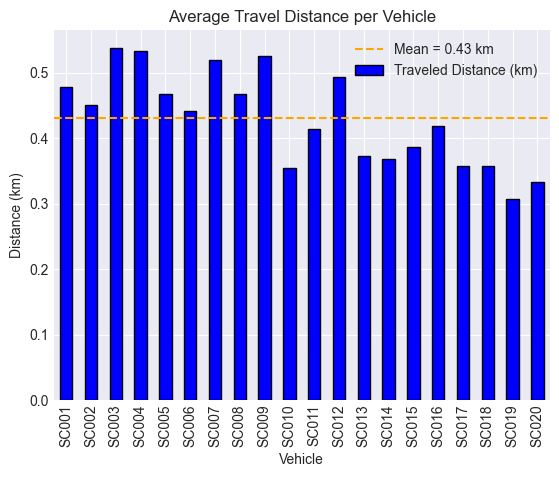

In [32]:
distance_df = complete_df[~complete_df["distance"].isna()]
avg_traveled_distance = distance_df['distance'].mean() / 10 ** 6
total_distance_traveled = distance_df.groupby("org:resource")["distance"].mean() / 10 ** 6

total_distance_traveled.plot(kind="bar", color="b", edgecolor="black", linewidth=1.0, label="Traveled Distance (km)")

plt.axhline(y=avg_traveled_distance, color='orange', linestyle='--', label=f'Mean = {avg_traveled_distance:.2f} km')

plt.title("Average Travel Distance per Vehicle")
plt.xlabel("Vehicle")
plt.ylabel("Distance (km)")
plt.legend();
plt.show()

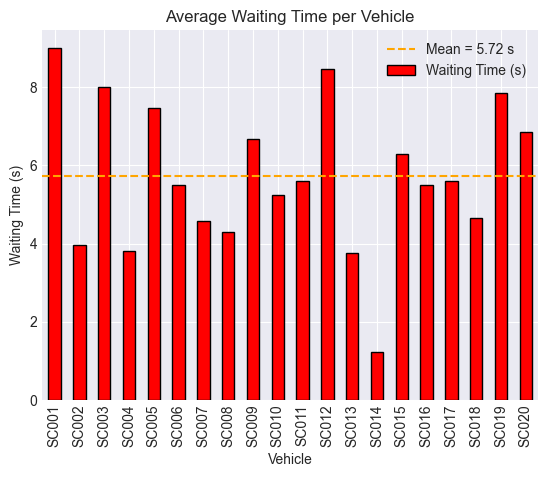

In [33]:
waiting_time_df = complete_df[~complete_df["waiting_time"].isna()]
avg_waiting_time = waiting_time_df["waiting_time"].mean()
ax = waiting_time_df.groupby("org:resource")["waiting_time"].mean().plot(kind="bar", color="r", edgecolor="black", linewidth=1.0, label="Waiting Time (s)")

plt.axhline(y=avg_waiting_time, color='orange', linestyle='--', label=f'Mean = {avg_waiting_time:.2f} s')

plt.title("Average Waiting Time per Vehicle")
plt.xlabel("Vehicle")
plt.ylabel("Waiting Time (s)")
plt.legend();
plt.show()

In [34]:
complete_df

,case_id,activity,timestamp,org:resource,lifecycle:transition,distance,driving_time,location,location_type,waiting_time,case:concept:name,concept:name,time:timestamp,@@index,@@case_index
1,CO_TFTU000001,dispatch vehicle to pick container,2024-11-14 10:31:13+00:00,SC001,complete,62657.0,11.0,,NaN,NaN,CO_TFTU000001,dispatch vehicle to pick container,2024-11-14 10:31:13+00:00,1,0
3,CO_TFTU000001,wait for free lane,2024-11-14 10:31:13+00:00,SC001,complete,NaN,NaN,QC001,QC,0.0,CO_TFTU000001,wait for free lane,2024-11-14 10:31:13+00:00,3,0
5,CO_TFTU000001,pick container,2024-11-14 10:32:13+00:00,SC001,complete,NaN,NaN,QC001,QC,NaN,CO_TFTU000001,pick container,2024-11-14 10:32:13+00:00,5,0
7,CO_TFTU000001,dispatch vehicle to drop container,2024-11-14 10:33:45+00:00,SC001,complete,510685.0,92.0,,NaN,NaN,CO_TFTU000001,dispatch vehicle to drop container,2024-11-14 10:33:45+00:00,7,0
9,CO_TFTU000001,wait for free lane,2024-11-14 10:33:45+00:00,SC001,complete,NaN,NaN,WS007.01,WS,0.0,CO_TFTU000001,wait for free lane,2024-11-14 10:33:45+00:00,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3423,CO_TFTU000286,wait for free lane,2024-11-14 10:31:57+00:00,SC008,complete,NaN,NaN,RAIL001.93,RAIL,0.0,CO_TFTU000286,wait for free lane,2024-11-14 10:31:57+00:00,3423,285
3425,CO_TFTU000286,pick container,2024-11-14 10:32:57+00:00,SC008,complete,NaN,NaN,RAIL001.93,RAIL,NaN,CO_TFTU000286,pick container,2024-11-14 10:32:57+00:00,3425,285
3427,CO_TFTU000286,dispatch vehicle to drop container,2024-11-14 10:34:43+00:00,SC008,complete,589167.0,106.0,,NaN,NaN,CO_TFTU000286,dispatch vehicle to drop container,2024-11-14 10:34:43+00:00,3427,285
3429,CO_TFTU000286,wait for free lane,2024-11-14 10:34:43+00:00,SC008,complete,NaN,NaN,WS003.01,WS,0.0,CO_TFTU000286,wait for free lane,2024-11-14 10:34:43+00:00,3429,285


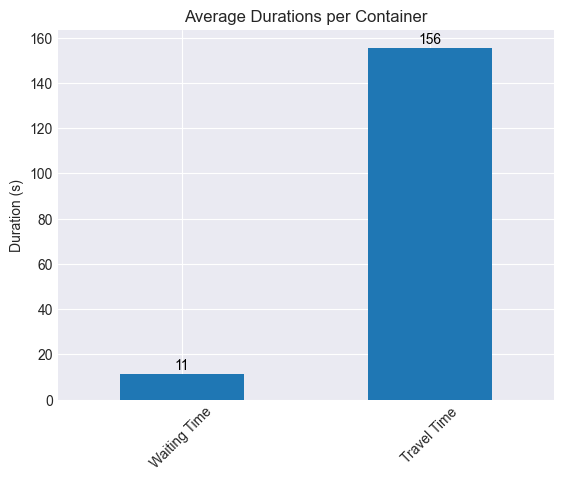

In [35]:
durations_per_container = complete_df.groupby("case_id")[["waiting_time", "driving_time"]].sum()

mean_durations = durations_per_container.mean()
ax = mean_durations.plot(kind="bar", rot=45)

for i, value in enumerate(mean_durations):
    plt.text(i, value + 0.5, f'{value:.0f}', ha='center', va='bottom', fontsize=10, color='black')

ax.set_title("Average Durations per Container")
ax.set_ylabel("Duration (s)")
ax.set_xticklabels(["Waiting Time", "Travel Time"]);

In [64]:
from vsim.analysis import analyze_location_occupancy

occupancy_df = analyze_location_occupancy(event_log_df=event_log_df, location="QC005")

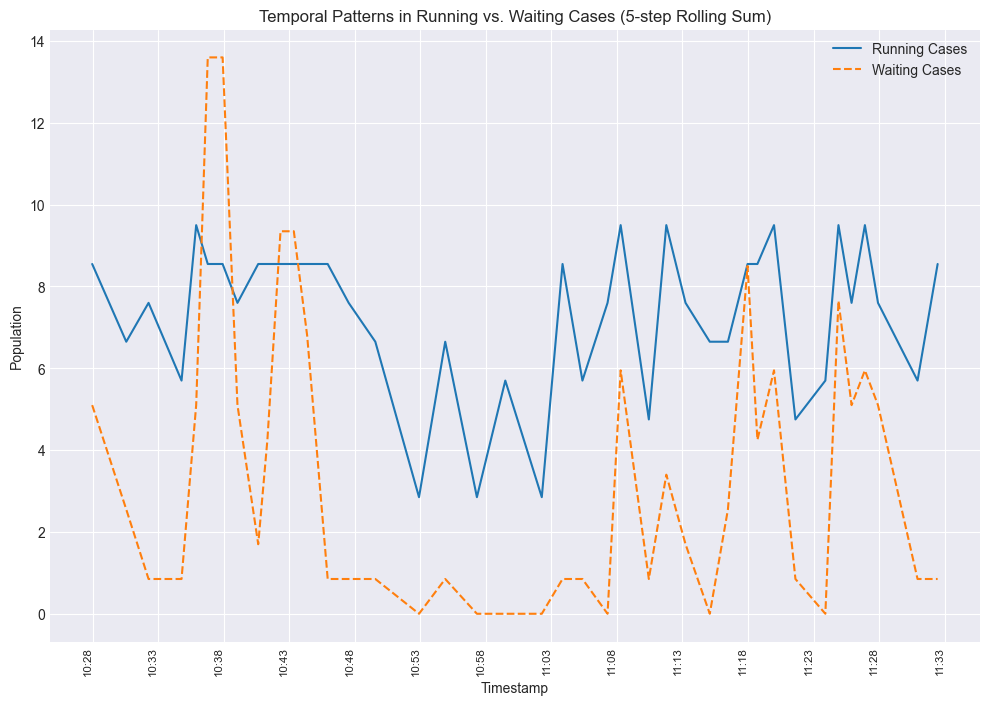

In [65]:
fig_agg, ax_agg = plt.subplots(1, 1, figsize=(12, 9), squeeze=True)
win_size = 5
rolling_df = occupancy_df[["running_count", "waiting_count"]].rolling(window=win_size, min_periods=1).agg('sum')[win_size - 1::win_size].reset_index()
rolling_df["timestamp"] = occupancy_df.loc[win_size - 1::win_size, 'timestamp'].reset_index(drop=True)

rolling_df.plot(x="timestamp", y="running_count", ax=ax_agg, label="Running Cases")
rolling_df.plot(x="timestamp", y="waiting_count", ax=ax_agg, style="--", xlabel="Timestamp", ylabel="Population", label="Waiting Cases")
ax_agg.set_title(f"Temporal Patterns in Running vs. Waiting Cases ({win_size}-step Rolling Sum)")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=win_size))
plt.xticks(rotation=90, fontweight='light', fontsize='small');

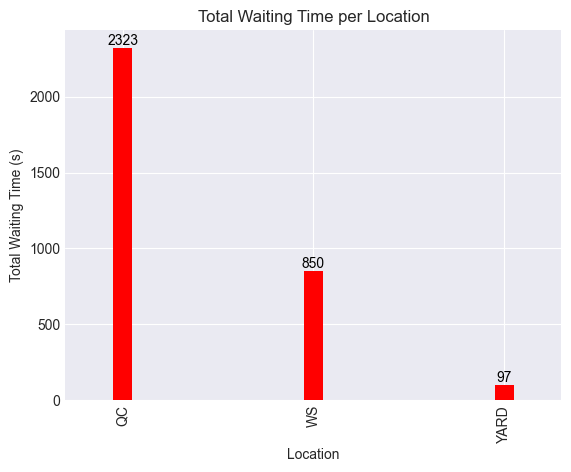

In [66]:
waiting_time_per_loc = complete_df.groupby("location_type", as_index=False)["waiting_time"].agg('sum')
waiting_time_per_loc = waiting_time_per_loc[waiting_time_per_loc["waiting_time"] > 0].reset_index(drop=True)
ax = waiting_time_per_loc.plot(x="location_type", kind="bar", color="r", legend=False, width=0.1)

plt.xlabel("Location")
plt.ylabel("Total Waiting Time (s)")
plt.title("Total Waiting Time per Location");

for i, row in waiting_time_per_loc.iterrows():
    plt.text(i, row['waiting_time'] + 0.5, f"{int(row['waiting_time'])}", ha='center', va='bottom', fontsize=10, color='black')

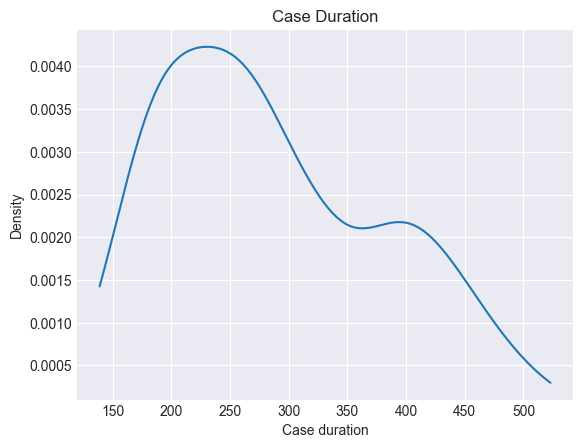

In [37]:
pm4py.view_case_duration_graph(event_log_df)